In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
import gender_guesser.detector as gender
from sklearn.model_selection import cross_val_score
from sklearn import ensemble

import time

In [55]:
# https://opendata.socrata.com/Government/2010-Report-to-Congress-on-White-House-Staff/vedg-c5sb
df = pd.read_csv("./data/2010_Report_to_Congress_on_White_House_Staff.csv")
df.head(2)

# Question: Is this a good dataset for this exercise? Should I add any other features?
# If not, what would a good dataset look like?

,Employee Name,Employee Status,Salary,Pay Basis,Position Title
0,"Abrams, Adam W.",Employee,$66300.00,Per Annum,WESTERN REGIONAL COMMUNICATIONS DIRECTOR
1,"Adams, Ian H.",Employee,$45000.00,Per Annum,EXECUTIVE ASSISTANT TO THE DIRECTOR OF SCHEDUL...


In [76]:
# Data cleaning and new columns

# Remove the '$' from the salary
df["Salary"] = df["Salary"].replace("[\$]", "", regex=True).astype(float)

# Add a column for higher paid employees
df["Top salary"] = df["Salary"] > np.median(df["Salary"])

# Add guessed gender
detector = gender.Detector()
name_indentifier = lambda x: 1 if detector.get_gender(x) == 'female' else 0
df["gender"] = df["Employee Name"].apply(lambda x: x.split(",")[1].split(" ")[1])
df["gender"] = df["gender"].apply(name_indentifier)

# Add bi-grams
# https://gist.github.com/jheard-tw/ebe8d75afef3c8967df609a3f51fbfde

# Add title lenght

# Get dummies for position
# dummies = df['Position Title'].replace("\,", "", regex=True).str.get_dummies(sep=' ')
dummies = df['Position Title'].str.split(r'\s+')
dummies = dummies.apply(lambda x: [x[i]+' '+x[i+1] for i in range(len(x)-1)] if len(x) > 1 else x)
dummies = dummies.str.join(sep="|").str.get_dummies(sep='|')
df = pd.concat([df, dummies], axis=1)

[ 0.52083333  0.5         0.4893617   0.53191489  0.53191489  0.55319149
  0.4893617   0.52173913  0.5         0.58695652]
Average:  0.522527366636
--- 0.2586400508880615 seconds ---


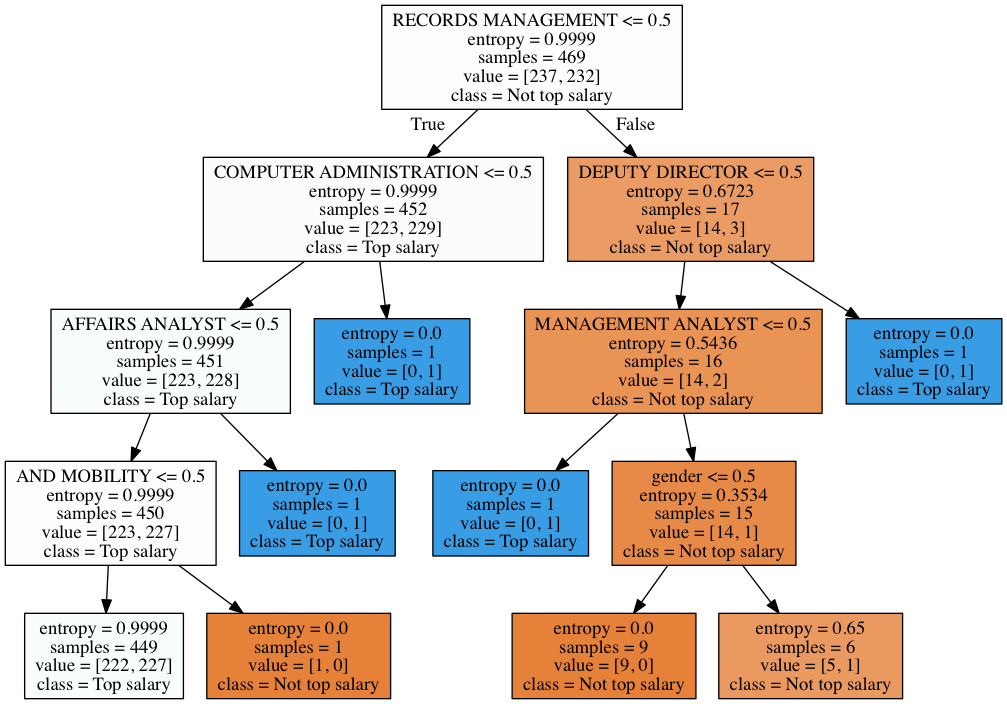

In [78]:
start_time = time.time()

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1330
)
X = df.drop(["Top salary", "Employee Name", "Employee Status", "Pay Basis", "Position Title", "Salary"], 1)
Y = df["Top salary"]
print(cross_val_score(decision_tree, X, Y, cv=10))
print("Average: ", np.mean(cross_val_score(decision_tree, X, Y, cv=10)))
print("--- %s seconds ---" % (time.time() - start_time))

decision_tree.fit(X, Y)
dot_data = tree.export_graphviz(
    decision_tree,
    out_file=None,
    feature_names=df.drop(["Top salary", "Employee Name", "Employee Status", "Pay Basis", "Position Title", "Salary"], 1).columns,
    class_names=['Not top salary', 'Top salary'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [71]:
start_time = time.time()
rfc = ensemble.RandomForestClassifier()
X = df.drop(["Top salary", "Employee Name", "Employee Status", "Pay Basis", "Position Title", "Salary"], 1)
Y = df["Top salary"]

print(cross_val_score(rfc, X, Y, cv=10))
print("Average: ", np.mean(cross_val_score(rfc, X, Y, cv=10)))
print("--- %s seconds ---" % (time.time() - start_time))

[ 0.79166667  0.85416667  0.89361702  0.95744681  0.87234043  0.85106383
  0.82978723  0.84782609  0.80434783  0.7826087 ]
Average:  0.835584335492
--- 0.8891079425811768 seconds ---
